# Сервис аренды самокатов GoFast
## Описание проекта
Анализ популярного сервиса аренды самокатов GoFast.  
Объектом исследования являются данные о некоторых пользователях из нескольких городов, а также об их поездках. 
Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.   
Сервисом можно пользоваться: c подпиской и без.
Тарифы подписок указаны в файле subscriptions_go.csv
  
  **План работ:**  

1 Загрузка и ознакомления с данными
  
  2 Предобработка данных(выявление пропусков, дубликатов итд)
  
  3 Анализ данных(нахождение зависимостей между данными, наличие аномалий, параметры распределений данных)
  
  4 Объединение данных в одну таблицу
  
  5 Проверка гипотез которые могут помочь бизнесу вырасти.
  
  6 Проверка вероятностного эффекта от проведения акций
  
  7 Общий вывод


In [1]:
#Импорт необходимых библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import factorial, sqrt
import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Загрузка данных

In [2]:
data_users = pd.read_csv('C:/Users/Artem/YA_Practicum/datasets/users_go.csv')
data_rides = pd.read_csv('C:/Users/Artem/YA_Practicum/datasets/rides_go.csv')
data_subscribes = pd.read_csv('C:/Users/Artem/YA_Practicum/datasets/subscriptions_go.csv')

<div class="alert-info" style="padding: 20px; border-radius: 10px">
Выведем первые 5 строк для ознакомления с данными каждого датафрейма.
</div>    

In [3]:
display(data_users.head())
display(data_rides.head())
display(data_subscribes.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Общая гистограмма для всех числовых столбцов таблиц
</div>

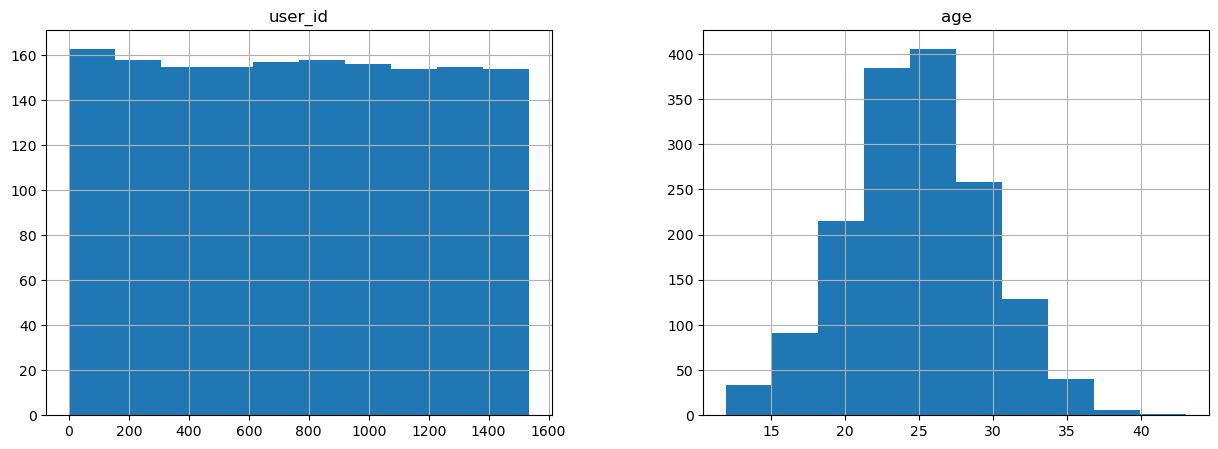

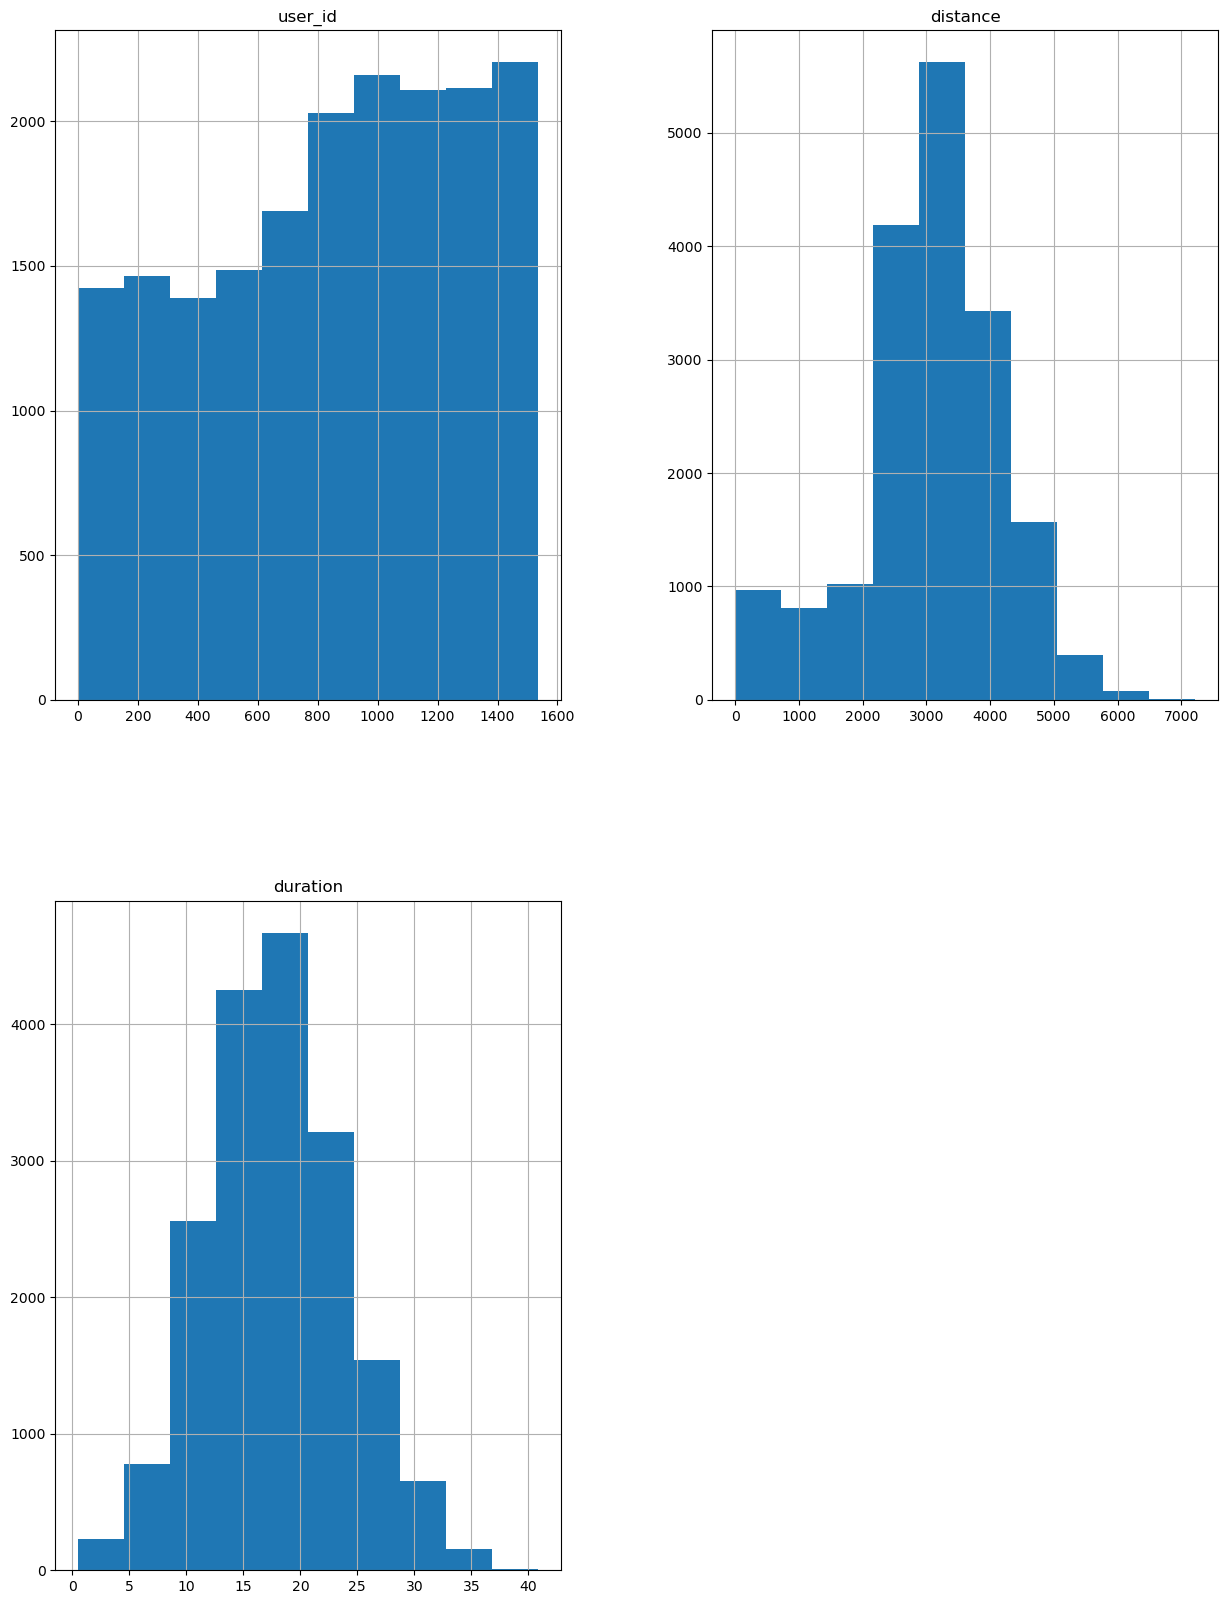

In [4]:
data_users.hist(figsize=(15, 5))
data_rides.hist(figsize=(15, 20))
plt.show()

In [5]:
data_users.info()
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


<div class="alert-info" style="padding: 20px; border-radius: 10px">
По типу данных столбцы первых двух датафреймов делятся:  
-Категориальные: name, city, subscription_type.  
-Количественные: age, distance, duration, date.

В датафрейме subscription содержится информация по тарифам с подпиской и без.
    </div>

## Шаг 2. Предобработка данных

Приведем столбец date к типу даты pandas

In [6]:
data_rides['date'] =  pd.to_datetime(data_rides['date'], format='%Y-%m-%d')

<div class="alert-info" style="padding: 20px; border-radius: 10px">
    Создадим дополнительный столбец с номером месяца 
    </div>

In [7]:
data_rides['month'] = data_rides['date'].dt.month
display(data_rides.head())
print(f"Данные представлены за период от {data_rides['date'].dt.to_period('M').min()} до {data_rides['date'].dt.to_period('M').max()}")

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Данные представлены за период от 2021-01 до 2021-12


<div class="alert-info" style="padding: 20px; border-radius: 10px">
    Проверим пропуски в данных data_users и data_rides
    </div>

In [8]:
print(data_users.isna().sum())
print(data_rides.isna().sum())

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64
user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Проверим дубликаты в датафреймах data_users и data_rides
    </div>

In [9]:
display(data_users.duplicated().value_counts())
display(data_rides.duplicated().value_counts())

False    1534
True       31
Name: count, dtype: int64

False    18068
Name: count, dtype: int64

<div class="alert-info" style="padding: 20px; border-radius: 10px">
В data_users содержится 31 явных дубликатов, удалим их.
</div>

In [10]:
data_users.drop_duplicates(inplace = True)
display(data_users.duplicated().value_counts())

False    1534
Name: count, dtype: int64

In [11]:
data_users.duplicated().sum()

0

## Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

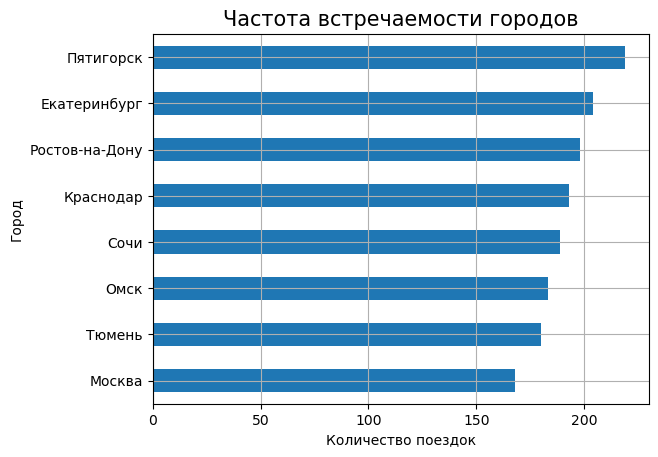

In [12]:
data_users_city = data_users['city'].value_counts()
display(data_users_city)
data_users_city.sort_values(ascending=True).plot(kind='barh',grid=True, legend = False)
plt.title('Частота встречаемости городов', fontsize= 15)
plt.ylabel('Город')
plt.xlabel('Количество поездок')
pd.options.mode.chained_assignment = None


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Самый популярный город Пятигорск - 219 пользователей.    

Меньше всего пользователей в Москве - 168
</div>

##### Соотношение пользователей с подпиской и без 

In [13]:
print(data_users['subscription_type'].value_counts())

subscription_type
free     835
ultra    699
Name: count, dtype: int64


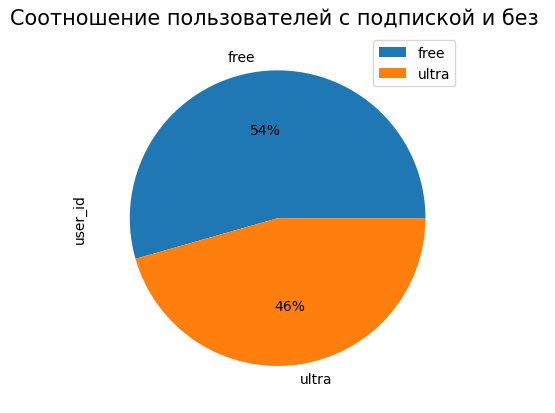

In [14]:
data_users.groupby(['subscription_type']).count().plot(kind='pie', y = 'user_id', autopct='%1.0f%%')
plt.title('Соотношение пользователей с подпиской и без ', fontsize= 15)
plt.show()

<div class="alert-info" style="padding: 20px; border-radius: 10px">
Количество пользователей без подписки(835) немного меньше чем с подпиской(699).
</div>    

##### Возраст пользователей

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

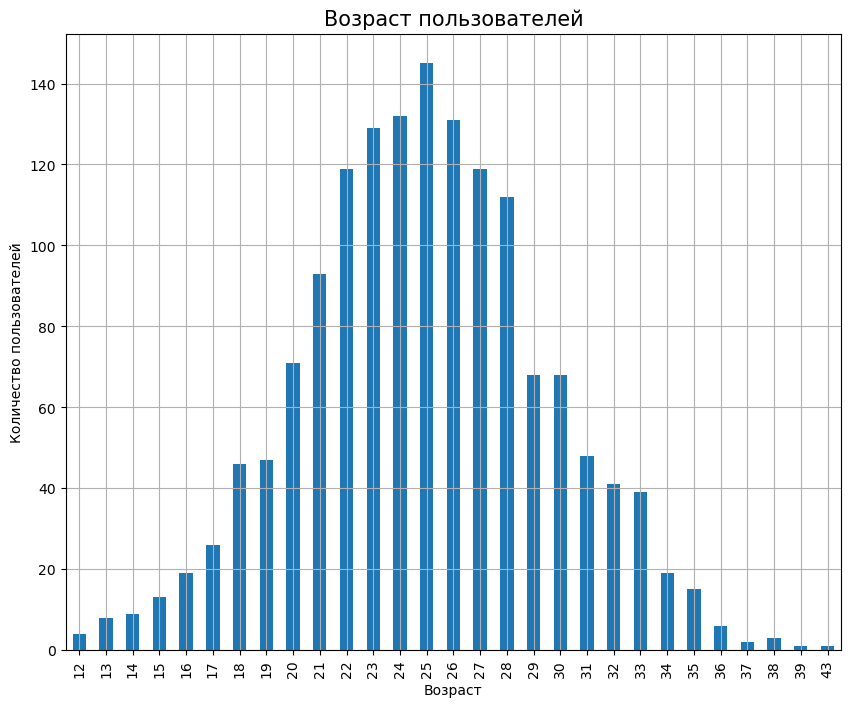

In [15]:
display(data_users['age'].describe())

data_users.pivot_table(index='age', values='user_id', aggfunc=['count']).plot(kind='bar',grid=True, legend = False,figsize=(10, 8))
plt.title('Возраст пользователей', fontsize= 15)
plt.ylabel('Количество пользователей')
plt.xlabel('Возраст')
pd.options.mode.chained_assignment = None

<div class="alert-info" style="padding: 20px; border-radius: 10px">
График принимает вид нормального распределения. Самый распространенный возраст 25 лет.
</div>

##### Расстояние, которое пользователь преодолел за одну поездку

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

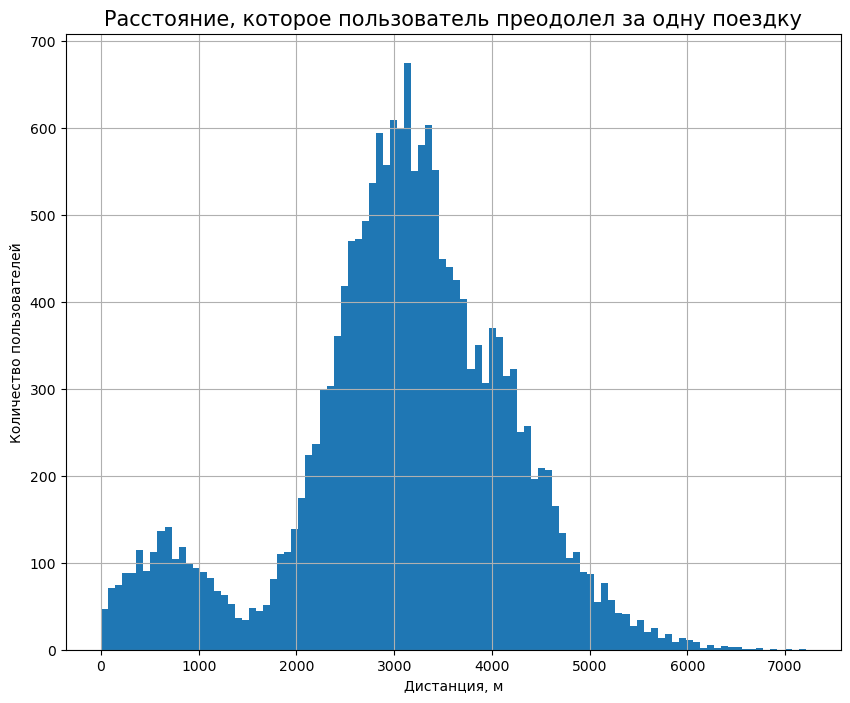

In [16]:
display(data_rides['distance'].describe())
data_rides['distance'].hist(figsize=(10, 8), bins=100)
plt.title('Расстояние, которое пользователь преодолел за одну поездку', fontsize= 15)
plt.xlabel('Дистанция, м')
plt.ylabel('Количество пользователей')
pd.options.mode.chained_assignment = None

<div class="alert-info" style="padding: 20px; border-radius: 10px">
Есть небольшая группа пользователей, длительная поездка которых составляет то 1,5км.   
    
Скорее всего это расстояние от метро до конечной или начальной точки.   
Самое распространенное расстояние около 3км.  
Минимальное расстояние 0.85км.  
Основной диапазон значений от 2.5км до 3.8км</div>


##### Продолжительность поездок

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Text(0, 0.5, 'Количество пользователей')

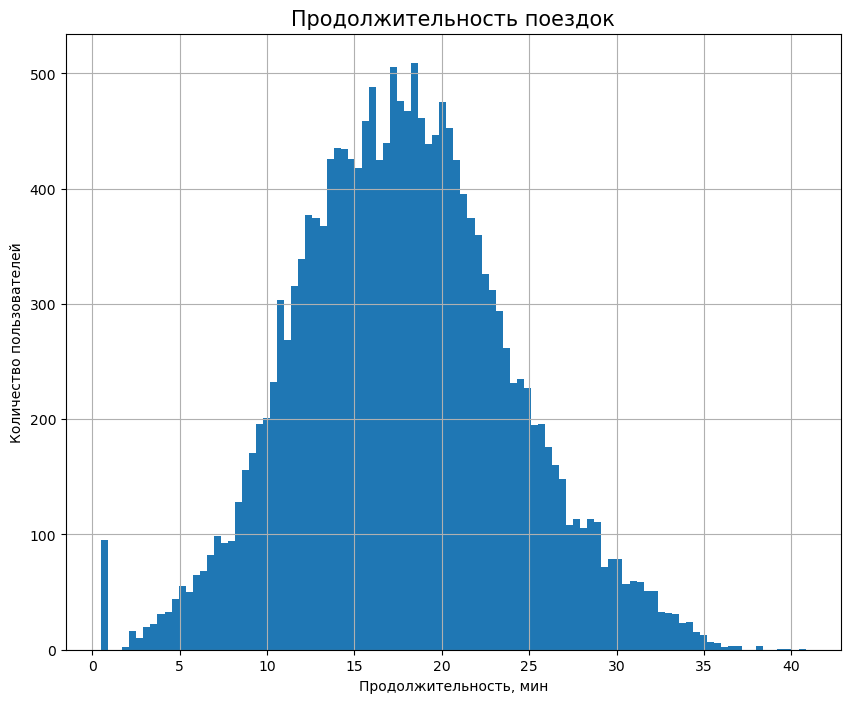

In [17]:
display(data_rides['duration'].describe())
data_rides['duration'].hist(figsize=(10, 8), bins=100)
plt.title('Продолжительность поездок', fontsize= 15)
plt.xlabel('Продолжительность, мин')
plt.ylabel('Количество пользователей')

<div class="alert-info" style="padding: 20px; border-radius: 10px">
Есть выброс в околонулевых значениях. Возможно это отмененные поездки. 
Минимальное значение 0.5мин, возможно это ошибка в данных так как много одинаковых значений, проверим их количество</div>

In [18]:
data_anomaly = data_rides[data_rides['duration'] == 0.5].shape[0]
print(f'Аномалии составляют: {round(data_anomaly/len(data_rides)*100, 2)} % от всей выборки.')

Аномалии составляют: 0.53 % от всей выборки.


<div class="alert-info" style="padding: 20px; border-radius: 10px">  
Так как количество аномалий мало относительно всей выборки и плата за эти поездки была списана(что может повлиять на расчет выручки в далбнейшем) удалять эти данные из датафрейма не будем.   

 Среднее время поездок составляет 17мин, максимальное 40 мин, минимальное 0.5 мин  
    Основной диапазон значений от 13 до 22 мин
</div>

## Шаг 4. Объединение данных

##### Добавим датафрейм data_rides к data_users

In [19]:
data_merge = data_users.merge(data_rides, on = 'user_id')
data_merge.head(20)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
5,1,Кира,22,Тюмень,ultra,2770.890808,16.650138,2021-10-09,10
6,1,Кира,22,Тюмень,ultra,3039.020292,14.927879,2021-10-19,10
7,1,Кира,22,Тюмень,ultra,2842.118050,23.117468,2021-11-06,11
8,1,Кира,22,Тюмень,ultra,3412.690668,15.238072,2021-11-14,11
9,1,Кира,22,Тюмень,ultra,748.690645,15.041884,2021-11-22,11


##### Создадим два датафрейма c данными о пользователях без подписки(data_merge_free) и с данными о пользователях с подпиской(data_merge_ultra) на освнове объедененного на предыдущем этапе датафрейма

In [20]:
data_merge_ultra = data_merge.query('subscription_type == "ultra"')
display(data_merge_ultra)
data_merge_free = data_merge.query('subscription_type == "free"')
display(data_merge_free)

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8
...,...,...,...,...,...,...,...,...,...
6495,699,Оксана,22,Москва,ultra,3973.046497,24.671163,2021-08-29,8
6496,699,Оксана,22,Москва,ultra,3288.702563,15.892886,2021-09-12,9
6497,699,Оксана,22,Москва,ultra,3076.159348,14.389525,2021-09-26,9
6498,699,Оксана,22,Москва,ultra,4707.845501,15.839579,2021-10-17,10


,user_id,name,age,city,subscription_type,distance,duration,date,month
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2
...,...,...,...,...,...,...,...,...,...
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11


#### Графики распределения расстояния и времени поездок для пользователей обеих категорий

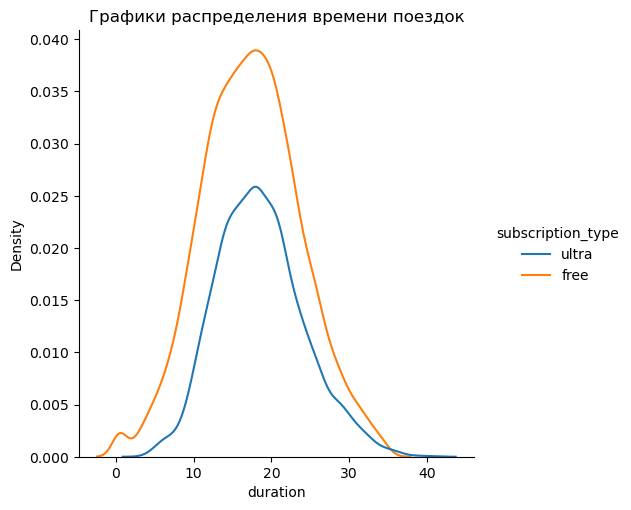

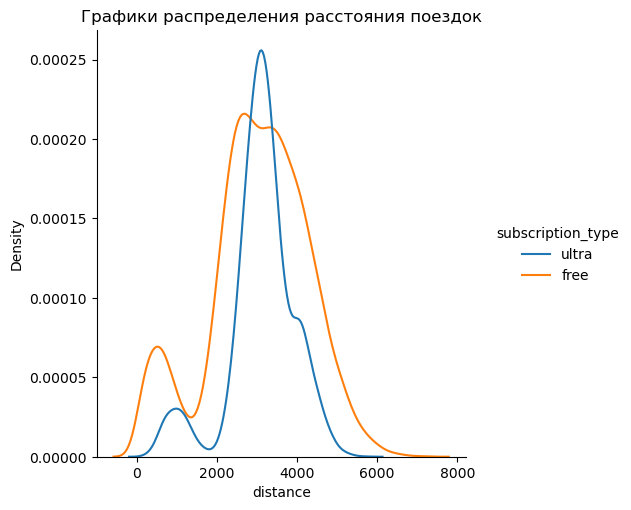

In [21]:
sns.displot(data_merge, x="duration", hue="subscription_type", kind="kde").set(title='Графики распределения времени поездок')
sns.displot(data_merge, x="distance", hue="subscription_type", kind="kde").set(title='Графики распределения расстояния поездок')

<div class="alert-info" style="padding: 20px; border-radius: 10px">
По времени:
Формы распеделения времени поездок схожи для категорий с подпиской и без, пики графиков находятся в районе 20 мин. Из-за большего количества поездок без подписок, график располагается выше.  

По расстоянию:
График распределения расстояния для пользователей с подпиской имеет более явный пик в районе 3км, это говорит о однотипных по расстоянию поездках. Так же пики значений для пользователей без подписки смещены ближе к 0. </div>


## Шаг 5. Подсчёт выручки

In [22]:
#Округлим до следующего целого числа продолжительность поездок
data_merge['duration']= np.ceil(data_merge['duration'])

#Создадим сводную таблицу с дополнительными столбцами по суммарному расстоянию и времени, кол-ву поездок, типу подписок 
data_total = data_merge.pivot_table(index=['user_id', 'month'], values = ['distance', 'duration', 'name', 'subscription_type'], aggfunc={'distance':'sum', 'duration':'sum', 'name':'count', 'subscription_type': 'min'})
data_total.columns = ['total_distance', 'total_duration','rides_count', 'subscription_type']
data_total = data_total.reset_index()
display(data_total)

#Добавим столбец помесячной стоимости поездок каждого пользователя
def income_func (row):
    if row['subscription_type'] == 'ultra':
        return data_subscribes['minute_price'].values[1]*row['total_duration'] + data_subscribes['subscription_fee'].values[1]
    if row['subscription_type'] == 'free':
        return data_subscribes['minute_price'].values[0]*row['total_duration'] + data_subscribes['start_ride_price'].values[0]*row['rides_count']

data_total['income'] = data_total.apply(income_func, axis=1)  
display(data_total)

,user_id,month,total_distance,total_duration,rides_count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,78.0,4,free


,user_id,month,total_distance,total_duration,rides_count,subscription_type,income
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,308.0
11327,1534,8,7622.453034,48.0,2,free,484.0
11328,1534,9,4928.173852,23.0,1,free,234.0
11329,1534,11,13350.015305,78.0,4,free,824.0


In [23]:
data_total.groupby('subscription_type')['income'].mean()

subscription_type
free     328.641365
ultra    362.792191
Name: income, dtype: float64

<div class="alert-info" style="padding: 20px; border-radius: 10px">
На данном шаге была посчитана выручка:   
   
Среднее значение помесячной выручки от пользователей с подпиской составляет 363руб.     
Среднее значение помесячной выручки от пользователей без подписки составляет 329руб.     
Среднее значение помесячной выручки от пользователей с подпиской выше примерно на 10%</div>

## Шаг 6. Проверка гипотез

##### Тратят ли пользователи с подпиской больше времени на поездки?

<div class="alert-info" style="padding: 20px; border-radius: 10px">
H0 - пользователи с подпиской тратят на поездку столько же времени что и пользователи без подписки    

H1 - пользователи с подпиской тратят на поездку больше времени чеми пользователи без подписки 
</div>

In [24]:
ultra_group = data_merge_ultra['duration']
free_group = data_merge_free['duration']
alpha = 0.05
results = st.ttest_ind(ultra_group, free_group, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в сервисе больше времени на поездку.
</div>    

##### Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?

<div class="alert-info" style="padding: 20px; border-radius: 10px">

H0 - пользователи с подпиской проезжают 3130 метров за одну подписку   
    H1 - пользователи с подпиской проезжают за одну поездку расстояние превышающее 3130 метров
</div>

In [25]:
ultra_group_dist = data_merge_ultra['distance']
wear_distance = 3130
alpha = 0.05
results = st.ttest_1samp(ultra_group_dist, wear_distance, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


<div class="alert-info" style="padding: 20px; border-radius: 10px">   
Выборочное среднее дистанции от значения, предполагаемого в H0, находится рядом и удовлетворяет условию в H1 c p-value 92%.
    Из этого следует что пользователи с подпиской вероятнее всего проезжают больше 3130м и тем самым сильнее изнашивают самокаты.
</div>
 

##### Гипотеза о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
H0 - пользователи с подпиской тратят в месяц столько же что и пользователи без подписки    

H1 - пользователи с подпиской тратят в месяц больше чем пользователи без подписки
</div>

In [26]:
ultra_group_income = data_total.query('subscription_type == "ultra"')['income']
free_group_income = data_total.query('subscription_type == "free"')['income']
alpha = 0.05
results = st.ttest_ind(ultra_group_income, free_group_income, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской тратят в сервисе меньше денег на поездку в месяц.
    </div>

##### Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?


<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Необходима проверка левосторонней альтернативной гипотезы о равенстве средних для зависимых (парных) выборок(истинное среднее генеральной совокупности до изменения должно быть меньше, чем истинное среднее генеральной совокупности после изменения).
</div>

## Распределения

##### Акция с раздачей промокодов

0.05043959099661155


<BarContainer object of 857 artists>

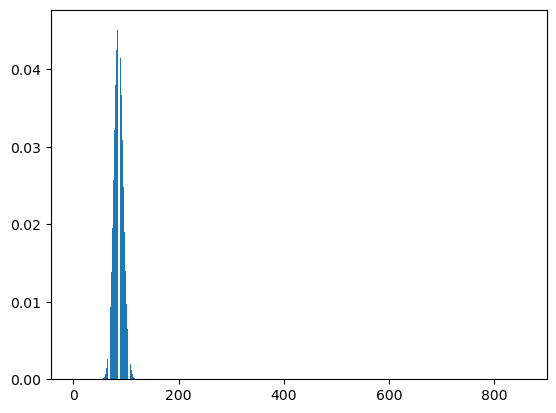

In [27]:
n = 856
p = 0.1 

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = 1 - distr.cdf(100)
print(result)

distr1 = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k) 
    distr1.append(prob)
    
plt.bar(range(0, n + 1), distr1)

<div class="alert-info" style="padding: 20px; border-radius: 10px"> 
Необходимо раздать 856 промокодов для вероятности невыполнения плана в 5%
    </div>

##### Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении.

In [28]:
n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))

distr = st.norm(mu, sigma)

result = distr.cdf(399500)
print(result)


0.15371708296369768


<div class="alert-info" style="padding: 20px; border-radius: 10px">
Вероятность что уведомление откроют 399,5 тыс пользователей, составляет 15%
</div>

## Шаг 7. Общий вывод 
В ходе работы над проектом исследованы три датафрейма о _пользователях, поездках и подписках._  
    В датафрейме subscription содержится информация по тарифам с подпиской и без.  
    Количество записей по поездкам равно 18068.  
    Данные представлены за период от января до декабря 2021 года     
    **На стадии предобработки было выявлено:**  
    -Пропусков в данных не обнаружено.  
    -В датафрейме с пользователями содержалось 31 явных дубликатов, которые впоследствии мы удалили.  
    -Так же обнаружена аномалия в данных. 95 записей были с продолжитьельностью 30 сек. Эти записи были удалены, так как составляли 0.5% от всей всей выборки и не повляили бы на объективность проверки гипотез.  
    **На шаге исследования было выявлено:**  
    -Самый популярный город Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168  
    -Количество пользователей без подписки составляет 835 человек(54%), а пользователей с подпиской 699 человек(46%)  
    -Самый распространенный возраст пользователей 25 лет.  
    -Минимальное расстояние поездки 0.85км. Основной диапазон значений от 2.5км до 3.8км  
    -Среднее время поездок составляет 17мин, максимальное 40 мин, минимальное 2 мин.Основной диапазон значений от 13 до 22 мин  
    **Построены графики распределения расстояния и времени поездок для пользователей обеих категорий:**  
    -Формы распеделения времени поездок схожи для категорий с подпиской и без, пики графиков находятся в районе 20 мин. Из-за большего количества поездок без подписок, график располагается выше.  
    -График распределения расстояния для пользователей с подпиской имеет более явный пик в районе 3км, это говорит о однотипных по расстоянию поездках.  
    **Подсчитана выручка:**  
    Среднее значение помесячной выручки от пользователей с подпиской составляет 363руб.  
    Среднее значение помесячной выручки от пользователей без подписки составляет 329руб.  
    Среднее значение помесячной выручки от пользователей с подпиской выше примерно на 10%  
    **На шаге проверки гипотез пришли к выводам:**  
    1)Есть основания говорить, что пользователи с подпиской тратят в сервисе больше времени на поездку.  
    2)Пользователи с подпиской проезжают по статистике вероятно больше 3130 метров, тем самым сильнее изнашивают самокаты.  
    3)Есть основания говорить, что пользователи с подпиской тратят в сервисе меньше денег на поездку в месяц.  
    Для проведения акции с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку с вероятностью успеха в 95% необходимо раздать 856 промокодов.  
    Вероятность того, что 1 млн разосланных push-уведомлений, разосланных отделом маркетинга, откроют не более 399,5 тыс. пользователей составляет 15%.    